# Deep Q-Network (DQN)
---
In this notebook, we will implement a DQN agent with OpenAI Gym's LunarLander-v3 environment.

### 1. Import the Necessary Packages

In [1]:
import gymnasium as gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Check PyTorch device and MPS availability for M3 MacBook acceleration
print("PyTorch Configuration:")
print(f"  PyTorch Version: {torch.__version__}")
print(f"  MPS Available: {torch.backends.mps.is_available()}")
print(f"  CUDA Available: {torch.cuda.is_available()}")
if torch.backends.mps.is_available():
    print("  ✓ Using MPS backend (Metal Performance Shaders on M3)")
    device = torch.device("mps")
elif torch.cuda.is_available():
    print("  Using CUDA GPU")
    device = torch.device("cuda:0")
else:
    print("  Using CPU")
    device = torch.device("cpu")
print(f"  Device: {device}")

PyTorch Configuration:
  PyTorch Version: 2.10.0
  MPS Available: True
  CUDA Available: False
  ✓ Using MPS backend (Metal Performance Shaders on M3)
  Device: mps


In [8]:
%pip install box2d-py --quiet

Note: you may need to restart the kernel to use updated packages.


### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below.

In [3]:
env = gym.make('LunarLander-v3')
env.reset(seed=0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


### 3. Test Environment and Rendering

In [5]:
# Close the old environment and create a new one with rendering enabled
env.close()
env = gym.make('LunarLander-v3', render_mode='rgb_array')

# Test a single episode with rendering
print("Testing environment and rendering...")
state, _ = env.reset(seed=42)
total_reward = 0
frames = []

for step in range(200):
    # Take a random action
    action = env.action_space.sample()
    
    # Get the frame before stepping
    frame = env.render()
    if frame is not None:
        frames.append(frame)
    
    # Execute the action
    state, reward, terminated, truncated, _ = env.step(action)
    total_reward += reward
    
    if terminated or truncated:
        break

print(f"Episode completed")
print(f"Total reward: {total_reward:.2f}")
print(f"Number of frames rendered: {len(frames)}")
print(f"Frame shape: {frames[0].shape if frames else 'No frames'}")
print(f"Rendering is working!" if frames else "✗ No frames rendered")

Testing environment and rendering...
Episode completed
Total reward: -136.36
Number of frames rendered: 117
Frame shape: (400, 600, 3)
Rendering is working!


### 3. Train the Agent with DQN

Run the code cell below to train the agent from scratch.

In [7]:
from dqn_agent import Agent

# Initialize the agent
agent = Agent(state_size=8, action_size=4, seed=0)
print(f"Agent initialized successfully on device: {agent.qnetwork_local.fc1.weight.device}")

Agent initialized successfully on device: mps:0


Episode 100	Average Score: -156.38
Episode 200	Average Score: -122.00
Episode 300	Average Score: -54.966
Episode 400	Average Score: 9.6965
Episode 500	Average Score: 162.85
Episode 600	Average Score: 185.04
Episode 700	Average Score: 188.54
Episode 800	Average Score: 200.72
Episode 900	Average Score: 226.36
Episode 1000	Average Score: 231.74
Episode 1100	Average Score: 219.34
Episode 1200	Average Score: 227.81
Episode 1300	Average Score: 244.56
Episode 1400	Average Score: 242.86
Episode 1500	Average Score: 241.33
Episode 1600	Average Score: 250.73
Episode 1700	Average Score: 255.96
Episode 1800	Average Score: 257.51
Episode 1811	Average Score: 260.40
Environment solved in 1711 episodes!	Average Score: 260.40


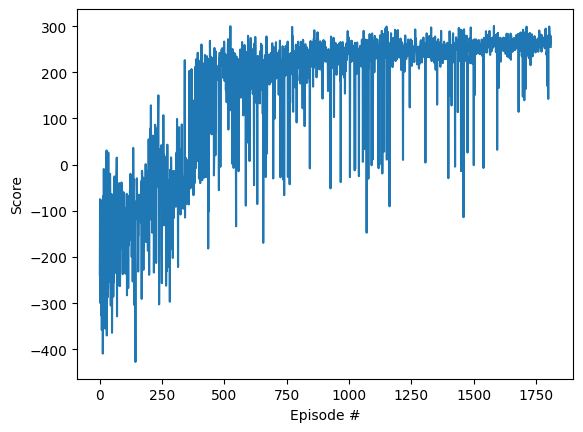

In [8]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state, _ = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, terminated, truncated, _ = env.step(action)
            agent.step(state, action, reward, next_state, terminated)
            state = next_state
            score += reward
            if terminated or truncated:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=260.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
# FASTER VARIANT: Aggressive learning rates and exploration decay
def dqn_fast(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.985):
    """Faster DQN variant with aggressive hyperparameters"""
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    
    for i_episode in range(1, n_episodes+1):
        state, _ = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, terminated, truncated, _ = env.step(action)
            agent.step(state, action, reward, next_state, terminated)
            state = next_state
            score += reward
            if terminated or truncated:
                break
        
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay * eps)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= 260.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint_fast.pth')
            break
    
    return scores

# Uncomment to run faster variant:
# scores_fast = dqn_fast()
# plt.plot(np.arange(len(scores_fast)), scores_fast)
# plt.ylabel('Score')
# plt.xlabel('Episode #')
# plt.title('Fast DQN Training')
# plt.show()

In [ ]:
# EXPERIMENT: Compare different hyperparameter configurations
# Run each variant in sequence and compare training curves

def compare_training_variants():
    """Train agents with different hyperparameter settings and compare results"""
    
    results = {}
    variants = {
        'baseline': {'eps_decay': 0.995, 'label': 'Baseline (eps_decay=0.995)'},
        'faster_decay': {'eps_decay': 0.985, 'label': 'Faster Decay (eps_decay=0.985)'},
        'fastest_decay': {'eps_decay': 0.975, 'label': 'Fastest Decay (eps_decay=0.975)'},
    }
    
    for variant_name, config in variants.items():
        print(f"\n{'='*60}")
        print(f"Training variant: {config['label']}")
        print(f"{'='*60}")
        
        # Reinitialize agent for each variant
        agent_variant = Agent(state_size=8, action_size=4, seed=0)
        
        scores = []
        scores_window = deque(maxlen=100)
        eps = 1.0
        
        for i_episode in range(1, 1001):  # 1000 episodes max for comparison
            state, _ = env.reset()
            score = 0
            for t in range(1000):
                action = agent_variant.act(state, eps)
                next_state, reward, terminated, truncated, _ = env.step(action)
                agent_variant.step(state, action, reward, next_state, terminated)
                state = next_state
                score += reward
                if terminated or truncated:
                    break
            
            scores_window.append(score)
            scores.append(score)
            eps = max(0.01, config['eps_decay'] * eps)
            
            if i_episode % 100 == 0:
                print(f'Episode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}')
            
            if np.mean(scores_window) >= 260.0:
                print(f"\nSolved in {i_episode-100} episodes!")
                break
        
        results[variant_name] = scores
    
    # Plot comparison
    plt.figure(figsize=(12, 6))
    for variant_name, scores in results.items():
        config = variants[variant_name]
        plt.plot(np.arange(len(scores)), scores, label=config['label'], alpha=0.7)
    
    plt.ylabel('Score', fontsize=12)
    plt.xlabel('Episode #', fontsize=12)
    plt.title('DQN Training: Hyperparameter Comparison', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return results

# Uncomment to run comparison:
# variant_results = compare_training_variants()

In [ ]:
# CUSTOM HYPERPARAMETER CONFIGURATION
# Modify these values to experiment with different agent settings

BUFFER_SIZE_CUSTOM = int(1e5)   # Experience replay buffer size (100k is standard)
BATCH_SIZE_CUSTOM = 128          # Increased from 64 for faster updates
GAMMA_CUSTOM = 0.99              # Discount factor (keep at 0.99)
TAU_CUSTOM = 1e-2                # Target network soft update rate (increased from 1e-3)
LR_CUSTOM = 1e-3                 # Learning rate (increased from 5e-4 to 1e-3)
UPDATE_EVERY_CUSTOM = 4          # How often to update the network

print(f"""
Custom Hyperparameter Configuration:
=====================================
BUFFER_SIZE: {BUFFER_SIZE_CUSTOM}
BATCH_SIZE: {BATCH_SIZE_CUSTOM}
GAMMA: {GAMMA_CUSTOM}
TAU: {TAU_CUSTOM}
LR: {LR_CUSTOM}
UPDATE_EVERY: {UPDATE_EVERY_CUSTOM}

Note: To use these hyperparameters, you need to modify dqn_agent.py
and reinitialize the agent. See next cell for instructions.
""")

### Instructions: How to Use Custom Hyperparameters

To apply custom hyperparameters:

1. **Edit dqn_agent.py** (lines 12-17):
   ```python
   BUFFER_SIZE = int(1e5)    # Change as needed
   BATCH_SIZE = 128          # Increase for faster learning
   GAMMA = 0.99
   TAU = 1e-2                # Increase to update target network faster
   LR = 1e-3                 # Increase learning rate
   UPDATE_EVERY = 4
   ```

2. **Reinitialize the agent** by running this cell:
   ```python
   agent = Agent(state_size=8, action_size=4, seed=0)
   ```

3. **Retrain** by running the training cell again.

**Quick Tuning Guide:**
- **Faster convergence**: Increase LR (1e-3), Increase TAU (1e-2), Increase BATCH_SIZE (128)
- **More stable training**: Decrease LR, Decrease TAU, Keep BATCH_SIZE moderate
- **Better exploration**: Decrease eps_decay (0.98 instead of 0.995)
- **Wider network**: Edit model.py, change fc1_units and fc2_units to 128

### Modify Agent Hyperparameters

Edit the values below to experiment with different learning configurations:

### Optional: Experiment with Hyperparameters

Try different hyperparameter combinations to speed up training. Below are some variants:

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [ ]:
import os
from IPython.display import Image, display
import imageio

# Close the old environment and create a new one with rendering enabled
env.close()
env = gym.make('LunarLander-v3', render_mode='rgb_array')

# load the weights from file if it exists
if os.path.exists('checkpoint.pth'):
    agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
    print("Trained weights loaded successfully!")
else:
    print("checkpoint.pth not found. Using current (untrained) agent weights.")
    print("Run cell 5 to train the agent first.")

# Watch the agent perform and save episodes as videos
for episode in range(3):
    state, _ = env.reset()
    episode_frames = []
    episode_reward = 0
    
    for step in range(200):
        action = agent.act(state)
        frame = env.render()
        if frame is not None:
            episode_frames.append(frame)
        state, reward, terminated, truncated, _ = env.step(action)
        episode_reward += reward
        if terminated or truncated:
            break
    
    # Save episode as GIF
    if episode_frames:
        filename = f'/tmp/episode_{episode}.gif'
        imageio.mimsave(filename, episode_frames, duration=0.05)
        print(f"Episode {episode + 1}: Reward = {episode_reward:.2f}, Frames = {len(episode_frames)}")
        display(Image(filename=filename))
            
env.close()

Trained weights loaded successfully!


: 

### 5. Explore

In this exercise, you have implemented a DQN agent and demonstrated how to use it to solve an OpenAI Gym environment.  To continue your learning, you are encouraged to complete any (or all!) of the following tasks:
- Amend the various hyperparameters and network architecture to see if you can get your agent to solve the environment faster.  Once you build intuition for the hyperparameters that work well with this environment, try solving a different OpenAI Gym task with discrete actions!
- You may like to implement some improvements such as prioritized experience replay, Double DQN, or Dueling DQN! 
- Write a blog post explaining the intuition behind the DQN algorithm and demonstrating how to use it to solve an RL environment of your choosing.  